IntSlider(value=12345, description='Seed', max=99999)

FloatSlider(value=100.0, description='a', max=2000.0, step=1.0)

IntSlider(value=-38, description='Closed value', max=50, min=-50)

FloatSlider(value=3.0, description='Closed avg time(scaled by delta_t)')

IntSlider(value=-33, description='Opened value', max=50, min=-50)

FloatSlider(value=0.8, description='Opened avg time(scaled by delta_t)')

FloatSlider(value=10.0, description='D', min=0.01, step=0.01)

SelectionSlider(description='Delta t', index=1, options=(0.001, 0.0001, 1e-05), value=0.0001)

IntSlider(value=50000, description='Records', max=100000, min=1000, step=1000)

VBox()

Checkbox(value=True, description='Takes previous values')

Dropdown(description='Random Force', options=('Gauss', 'Levy'), value='Gauss')

Dropdown(description='Autocorrelation method', index=2, options=('DFA', 'FFT', 'All'), value='All')

IntSlider(value=100, description='FFT lags', max=200, min=30, step=10)

Checkbox(value=False, description='Draw breakpoints')

Button(description='Run Model', style=ButtonStyle())

Button(description='Run Model (Test)', style=ButtonStyle())

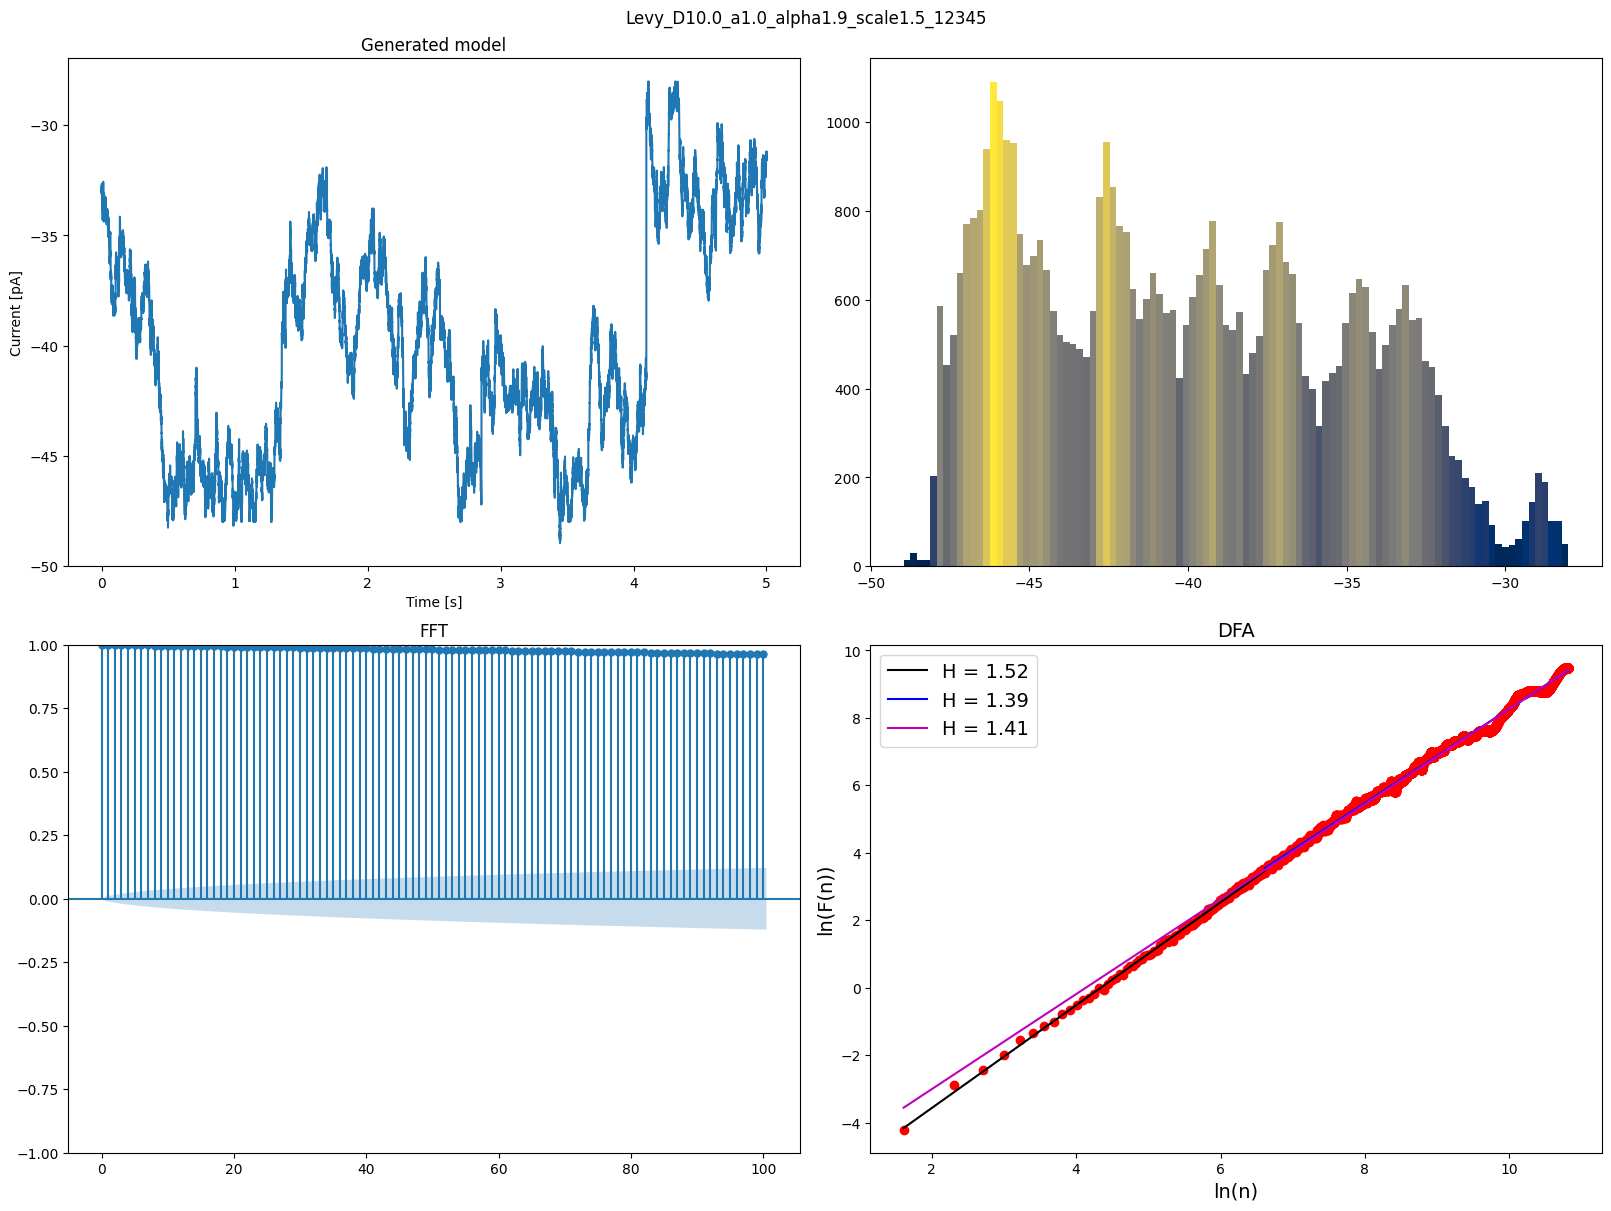

In [1]:
from ion_channel import InteractiveIonChannel

IIC = InteractiveIonChannel()
IIC.interact()